In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 80)
pd.set_option('display.max_rows', 100)

sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

expt_dir = '/net/pulsar/home/koes/mtr22/gan/torch_training'
os.chdir(expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/torch_training'

In [2]:
template_file = 'train.sh'
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=18
#SBATCH --partition=dept_gpu
#SBATCH --gres=gpu:1
#SBATCH -C M12
#SBATCH --mem=32gb
#SBATCH --time=672:00:00
#SBATCH --qos=normal
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --dependency=singleton
{job_params}
source ~/.bashrc
cd $SLURM_SUBMIT_DIR

python3 $LIGAN_ROOT/train.py \\
    --random_seed {random_seed} \\
    --data_root {data_root} \\
    --rec_molcache {rec_molcache} \\
    --lig_molcache {lig_molcache} \\
    --train_file {train_file} \\
    --test_file {test_file} \\
    --batch_size {batch_size} \\
    --rec_map_file {rec_map_file} \\
    --lig_map_file {lig_map_file} \\
    --model_type {model_type} \\
    --skip_connect {skip_connect} \\
    --kldiv_loss_wt {kldiv_loss_wt} \\
    --recon_loss_wt {recon_loss_wt} \\
    --gan_loss_type {gan_loss_type} \\
    --gan_loss_wt {gan_loss_wt} \\
    --disc_grad_norm {disc_grad_norm} \\
    --max_iter {max_iter} \\
    --test_interval {test_interval} \\
    --n_test_batches {n_test_batches} \\
    --save_interval {save_interval} \\
    --out_prefix {job_name}
'''
with open(template_file, 'w') as f:
    f.write(template)

In [3]:
# for ligand-only models
lig_param_space = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/mtr22/molport',
    rec_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_lig.molcache2',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_test0.types',
    model_type=['AE', 'VAE', 'GAN', 'VAEGAN'],
    skip_connect=False
)

# for receptor-conditional models
rec_param_space = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output',
    rec_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_lig.molcache2',
    train_file='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types',
    test_file='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_test0.types',
    model_type=['CE', 'CVAE', 'CGAN', 'CVAEGAN'],
    skip_connect=True
)

# general parameters
gen_param_space = param_search.ParamSpace(
    random_seed=0,
    batch_size=10,
    rec_map_file='/net/pulsar/home/koes/mtr22/gan/data/my_rec_map',
    lig_map_file='/net/pulsar/home/koes/mtr22/gan/data/my_lig_map',
    kldiv_loss_wt=0.1,
    recon_loss_wt=1,
    gan_loss_wt=10,
    gan_loss_type='w',
    disc_grad_norm='2',
    max_iter=1000000,
    test_interval=100,
    n_test_batches=10,
    save_interval=10000
)

rec_param_space.update(gen_param_space)
lig_param_space.update(gen_param_space)

len(rec_param_space), len(lig_param_space)

(4, 4)

In [161]:
job_files = param_search.setup(
    expt_dir=expt_dir,
    name_format='train_{model_type}_6',
    template_file='train.sh',
    param_space=list(rec_param_space) + list(lig_param_space)
)
job_files

['/net/pulsar/home/koes/mtr22/gan/torch_training/train_CE_6/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAE_6/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_6/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_6/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_6/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAE_6/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_6/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_6/train.sh']

In [168]:
job_ids = param_search.submit(job_files)
print(' '.join(map(str,job_ids)))

[6733345, 6733346, 6733347, 6733348, 6733349, 6733350, 6733351, 6733352]

In [4]:
job_ids = [6733345, 6733346, 6733347, 6733348, 6733349, 6733350, 6733351, 6733352]
param_search.status(job=','.join(map(str, job_ids)))

,job_id,queue,job_name,user,job_state,runtime,walltime,node_id,work_dir
0,6733350,dept_gpu,train_VAE_6,mtr22,PD,0:00,28-00:00:00,(Resources),/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAE_6
1,6733351,dept_gpu,train_GAN_6,mtr22,PD,0:00,28-00:00:00,(Priority),/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_6
2,6733352,dept_gpu,train_VAEGAN_6,mtr22,PD,0:00,28-00:00:00,(Priority),/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_6
3,6733345,dept_gpu,train_CE_6,mtr22,R,2-07:52:24,28-00:00:00,g014,/net/pulsar/home/koes/mtr22/gan/torch_training/train_CE_6
4,6733346,dept_gpu,train_CVAE_6,mtr22,R,2-07:52:24,28-00:00:00,g015,/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAE_6
5,6733347,dept_gpu,train_CGAN_6,mtr22,R,2-07:52:24,28-00:00:00,g016,/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_6
6,6733348,dept_gpu,train_CVAEGAN_6,mtr22,R,2-07:52:24,28-00:00:00,g018,/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_6
7,6733349,dept_gpu,train_AE_6,mtr22,R,1-11:26:46,28-00:00:00,g017,/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_6


In [5]:
import glob
job_files = dict()
for i in range(10):
    job_files[i] = glob.glob(expt_dir + '/*_{}/train.sh'.format(i))

In [6]:
errors = param_search.errors(job_files[6])
errors

[None,
 None,
 None,
 None,
 None,
 'slurmstepd: error: *** JOB 6733312 ON g015 CANCELLED AT 2021-03-08T16:02:42 ***',
 'slurmstepd: error: *** JOB 6733313 ON g018 CANCELLED AT 2021-03-08T16:02:42 ***',
 'slurmstepd: error: *** JOB 6733314 ON g016 CANCELLED AT 2021-03-08T16:02:42 ***']

In [12]:
# READ IN METRIC FILES
metrics = param_search.metrics(job_files[6][:4], metric_pat='(.*)\.metrics')

In [13]:
def dtype(s):
    return s.dtype

metric_index_cols = ['iteration', 'disc_iter', 'phase', 'model', 'batch']
all_index_cols = list(rec_param_space.keys()) + metric_index_cols

metrics[all_index_cols].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
data_root,object,1,[/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output]
rec_molcache,object,1,[/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_rec.molcache2]
lig_molcache,object,1,[/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_lig.molcache2]
train_file,object,1,[/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types]
test_file,object,1,[/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_test0.types]
model_type,object,4,"[CE, CVAE, CGAN, CVAEGAN]"
skip_connect,bool,1,[True]
random_seed,int64,1,[0]
batch_size,int64,1,[10]
rec_map_file,object,1,[/net/pulsar/home/koes/mtr22/gan/data/my_rec_map]


In [15]:
#metrics['iteration'] = metrics['iteration'].mask(metrics['iteration'].isna(), metrics['gen_iter'], axis=0)
#metrics['recon_loss_fixed'] = metrics['recon_loss'] * (19*48*48*48) / 2

metrics['model'] = metrics['model'].fillna('gen')
metrics['real'] = metrics['real'].fillna(False)

metrics[
    metrics['iteration'] == metrics.groupby('model_type')['iteration'].transform(max)
].set_index(['model_type', 'iteration', 'phase', 'model', 'batch', 'real'])[
    ['loss', 'kldiv_loss', 'recon_loss', 'gan_loss', 'gen_grad_norm', 'disc_grad_norm', 'lig_norm', 'lig_gen_norm']
]

loss  kldiv_loss  \
model_type iteration phase model batch real                            
CE         210300    test  gen   0     False  646.956848         NaN   
                                 1     False  605.877258         NaN   
                                 2     False  545.046509         NaN   
                                 3     False  630.039734         NaN   
                                 4     False  622.786804         NaN   
                                 5     False  605.717712         NaN   
                                 6     False  712.723145         NaN   
                                 7     False  776.115845         NaN   
                                 8     False  754.371826         NaN   
                                 9     False  798.817139         NaN   
CVAE       181000    test  gen   0     False  134.835770  314.499023   
                                 1     False  154.047684  300.443939   
                                 2     False  116.299866  299.598450   
                                 3     False  151.095795  312.383148   
                                 4     False  120.738670  285.686768   
                                 5     False  263.254883  342.477722   
                                 6     False  147.736679  334.469055   
                                 7     False  154.902466  319.023407   
                                 8     False  161.716797  296.149902   
                                 9     False  112.903961  267.174957   
CGAN       116400    test  disc  0     True          NaN         NaN   
                                 1     False         NaN         NaN   
                                 2     True          NaN         NaN   
                                 3     False         NaN         NaN   
                                 4     True          NaN         NaN   
                                 5     False         NaN         NaN   
                                 6     True          NaN         NaN   
                                 7     False         NaN         NaN   
                                 8     True          NaN         NaN   
                                 9     False         NaN         NaN   
                           gen   0     False         NaN         NaN   
                                 1     False         NaN         NaN   
                                 2     False         NaN         NaN   
                                 3     False         NaN         NaN   
                                 4     False         NaN         NaN   
                                 5     False         NaN         NaN   
                                 6     False         NaN         NaN   
                                 7     False         NaN         NaN   
                                 8     False         NaN         NaN   
                                 9     False         NaN         NaN   
CVAEGAN    107700    test  disc  0     True          NaN         NaN   
                                 1     False         NaN         NaN   
                                 2     True          NaN         NaN   
                                 3     False         NaN         NaN   
                                 4     True          NaN         NaN   
                                 5     False         NaN         NaN   
                                 6     True          NaN         NaN   
                                 7     False         NaN         NaN   
                                 8     True          NaN         NaN   
                                 9     False         NaN         NaN   
                           gen   0     False         NaN         NaN   
                                 1     False         NaN         NaN   
                                 2     False         NaN         NaN   
                                 3     False         NaN         NaN   
                    

No numeric types to aggregate object disc_grad_norm
No numeric types to aggregate object disc_grad_norm


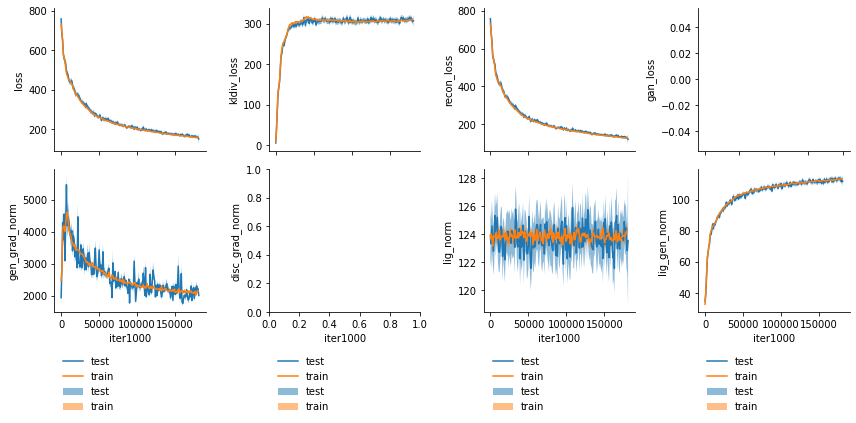

In [37]:
import numpy as np
import scipy.stats
import param_search

def filled_lines(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue):
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(scipy.stats.sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h)
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
metrics['iter1000'] = ((metrics['iteration'] // 1000)*1000).astype(int)

fig = param_search.plot(
    metrics[
        (metrics['model_type'] == 'CVAE') &
        (metrics['model'] != 'disc') &
        (metrics['model'] != 'disc')
    ],
    x='iter1000',
    y=['loss', 'kldiv_loss', 'recon_loss', 'gan_loss', 'gen_grad_norm', 'disc_grad_norm', 'lig_norm', 'lig_gen_norm'],
    hue='phase',
    plot_func=filled_lines,
    n_cols=4
)